In [1]:
print("All Ok")

All Ok


In [2]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [3]:
model="deepseek-r1-distill-llama-70b"

### Load the Model

In [4]:
from langchain_groq import ChatGroq

llm=ChatGroq(model_name=model)

llm.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.083022179, 'prompt_time': 5.5009e-05, 'queue_time': 0.052876066, 'total_time': 0.083077188}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--c9b0904b-6bff-406d-82c3-06858a124f09-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})

In [5]:
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [6]:
import operator
from typing import List
from langgraph.graph.message import add_messages
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [7]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [8]:
# HumanMessage("hi how are you?")

In [9]:
# HumanMessage(["hi how are you?"])

### Only testing code

In [10]:
state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.192363941, 'prompt_time': 0.000195216, 'queue_time': 0.053586964, 'total_time': 0.192559157}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--38f2ef50-5001-4ea8-9cb9-d10c3d06ccdf-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

In [11]:
# from langchain_core.messages import AnyMessage
# # class MessagesState(TypedDict):
# #     messages: Annotated[list[AnyMessage], add_messages]


# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]

### Design a Simple Workflow without Tool Calling

In [12]:
workflow=StateGraph(MessagesState)

In [13]:
workflow.add_node("mybot",call_model)

In [14]:
workflow.add_edge(START,"mybot")

In [15]:
workflow.add_edge("mybot",END)

In [16]:
app = workflow.compile()

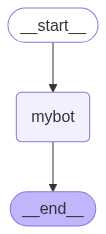

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
input={"messages":["hi hello how are you?"]}

In [19]:
app.invoke(input)

{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='24b006f6-29f4-4fa6-b8a9-28099e3f5de8'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.198358598, 'prompt_time': 0.000198216, 'queue_time': 0.052973464, 'total_time': 0.198556814}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--ebf502b4-ede4-4307-a231-f8933c1a5626-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

In [20]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from mybot Node
_______
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.184770182, 'prompt_time': 0.000187177, 'queue_time': 0.057895827000000004, 'total_time': 0.184957359}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--bc8ddd18-9883-4e0e-b37c-217cf537203d-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}




### Workflow with Tool Calling

In [22]:
@tool
def search(query: str):
    """this is a custom tool for weather"""
    if "delhi" in query.lower():
        return "The temp is 45 degrees and sunny"
    return "The temp is 25 degrees and cloudy"

### Testing the Tool

In [23]:
search.invoke("what is a temp in kashmir?")

'The temp is 25 degrees and cloudy'

In [24]:
search.invoke("what is a temp in Delhi?")

'The temp is 45 degrees and sunny'

In [25]:
search

StructuredTool(name='search', description='this is a custom tool for weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C9BF2532E0>)

In [26]:
llm.invoke("what is a weather in delhi?")

AIMessage(content='<think>\n\n</think>\n\nAs of my last update in July 2024, I cannot provide real-time weather information. However, Delhi generally experiences a humid subtropical climate with extreme summer and winter conditions. Summers (April to October) are typically very hot with temperatures often reaching 40°C (104°F) or higher. Winters (November to February) can be quite cold, especially in December and January, with temperatures sometimes dropping to around 5°C (41°F). The monsoon season usually starts in July and lasts until September, bringing heavy rainfall and humidity. For the most accurate and current weather information, I recommend checking a reliable weather forecasting service or app.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 11, 'total_tokens': 146, 'completion_time': 0.512793776, 'prompt_time': 0.000271077, 'queue_time': 0.052264243, 'total_time': 0.513064853}, 'model_name': 'deepseek-r1-distill-llama-70

### Binding a tool to the LLM

`Special Note: use some good for agentic workflow since opensource model might not give you the correct output`

In [27]:
tools = [search]

In [28]:
llm_with_tools = llm.bind_tools(tools)

### Testing the LLM with Tools

In [30]:
response = llm_with_tools.invoke("what is the weather in Delhi?")

response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'brr4tandg', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 195, 'prompt_tokens': 130, 'total_tokens': 325, 'completion_time': 0.913587273, 'prompt_time': 0.008334332, 'queue_time': 0.053422062, 'total_time': 0.921921605}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2dd459c4-b881-494a-8048-34913804a2c1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'brr4tandg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 195, 'total_tokens': 325})

In [31]:
response.content

''

In [32]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'brr4tandg',
  'type': 'tool_call'}]

In [33]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_with_tools.invoke(question)
    return {"messages":[response]}

In [34]:
input={"messages":["what is a weather in delhi?"]}

In [35]:
response=call_model(input)

In [36]:
response["messages"][-1].content

''

In [37]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi weather'},
  'id': '08wdj06dx',
  'type': 'tool_call'}]

### Create a router function

now whatever will come from call_model router funtion will redirect this to the appropriate tool

In [38]:
def router_func(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [39]:
tools

[StructuredTool(name='search', description='this is a custom tool for weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C9BF2532E0>)]

In [40]:
tool_node = ToolNode(tools)

In [41]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is a custom tool for weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C9BF2532E0>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [42]:
workflow2 = StateGraph(MessagesState)

In [43]:
workflow2.add_node("llmwithtool",call_model)

workflow2.add_node("mytools",tool_node)

workflow2.add_edge(START,"llmwithtool")

workflow2.add_conditional_edges("llmwithtool",
                                router_func,
                                {"tools":"mytools",
                                 END:END})

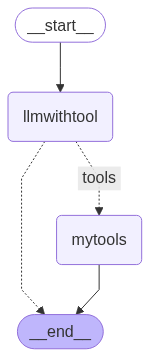

In [45]:
app2 = workflow2.compile()

display(Image(app2.get_graph().draw_mermaid_png()))

In [46]:
response=app2.invoke({"messages":["what is a weather in bengraluru?"]})

In [47]:
response["messages"][-1].content

'The temp is 25 degrees and cloudy'

In [48]:
app2.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='4f11a06c-cec2-4045-ba05-d4afb4d9b060'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vrw71em6f', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 131, 'total_tokens': 242, 'completion_time': 0.511399055, 'prompt_time': 0.008439734, 'queue_time': 0.075758406, 'total_time': 0.519838789}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0a864cce-9b17-460e-adf5-cc53d071ade4-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'vrw71em6f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 111, 'total_tokens': 242}),
  ToolMessage(content='The temp is 45 degrees and sunny', name='searc

In [49]:
app2.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='52374b02-ed3b-42de-b51a-8e98f7b452af'),
  AIMessage(content="Hello! I'm just an AI, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 291, 'prompt_tokens': 128, 'total_tokens': 419, 'completion_time': 1.224889701, 'prompt_time': 0.008216616, 'queue_time': 0.052904854, 'total_time': 1.233106317}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--e31a49cc-89b8-4144-a6ee-78b65cebbd84-0', usage_metadata={'input_tokens': 128, 'output_tokens': 291, 'total_tokens': 419})]}

In [50]:
workflow2.add_edge("mytools","llmwithtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [51]:
app3 = workflow2.compile()

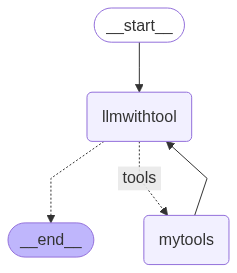

In [52]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [53]:
for output in app3.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1atydr5d9', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 244, 'prompt_tokens': 132, 'total_tokens': 376, 'completion_time': 1.06911113, 'prompt_time': 0.008476521, 'queue_time': 0.05346409, 'total_time': 1.077587651}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d7d4880d-802b-4dd8-a2c2-4ae859404f78-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in New Delhi'}, 'id': '1atydr5d9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 244, 'total_tokens': 376})]}


here is output from mytools
_______
{'messages': [ToolMessage(content='The temp is 45 degrees and sunny', name='search', id='e05e61c8-9fd0-4047-b033-8c7e1978c89a'

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [54]:
"what is a weather in delhi can you tell me some good hotel for staying in north delhi"

'what is a weather in delhi can you tell me some good hotel for staying in north delhi'

In [55]:
from langgraph.checkpoint.memory import MemorySaver

In [56]:
memory=MemorySaver()

In [57]:
workflow3=StateGraph(MessagesState)

workflow3.add_node("llmwithtool",call_model)

workflow3.add_node("mytools",tool_node)

workflow3.add_edge(START,"llmwithtool")

workflow3.add_conditional_edges("llmwithtool",
                                router_func,
                                {"tools":"mytools",
                                 END:END})

workflow3.add_edge("mytools","llmwithtool")

In [58]:
app4 = workflow3.compile(checkpointer=memory)

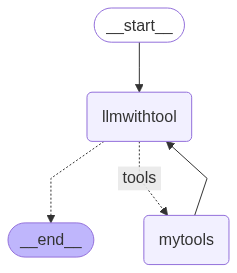

In [59]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [60]:
config={"configurable": {"thread_id": "1"}}

In [61]:
events=app4.stream(
    {"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values"
    )

In [62]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (z7x9chhdg)
 Call ID: z7x9chhdg
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

The temp is 45 degrees and sunny
================================== Ai Message ==================================
Tool Calls:
  search (7v324km3s)
 Call ID: 7v324km3s
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

The temp is 45 degrees and sunny
================================== Ai Message ==================================

The weather in New Delhi is 45 degrees and sunny.


In [63]:
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

In [64]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (njavy643f)
 Call ID: njavy643f
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

The temp is 25 degrees and cloudy
================================== Ai Message ==================================


In [65]:
config

{'configurable': {'thread_id': '1'}}

In [66]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T06:18:53.330184+00:00',
 'id': '1f048e77-1dae-6650-800a-c9fdca69ee2a',
 'channel_versions': {'__start__': '00000000000000000000000000000009.0.20336642142259664',
  'messages': '00000000000000000000000000000012.0.013607460082193379',
  'branch:to:llmwithtool': '00000000000000000000000000000012.0.051054862933646916',
  'branch:to:mytools': '00000000000000000000000000000011.0.6711725595953016'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000008.0.16502439145500525'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000011.0.9721215896119404'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000010.0.9590506101499455'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='a1157a34-2ef9-404e-8d5d-1617ba8a9478'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'z7x9chhdg', 'functi

In [67]:
events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

In [68]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================
Tool Calls:
  search (kvqjfc7f4)
 Call ID: kvqjfc7f4
  Args:
    query: city with 25 degrees temperature
================================= Tool Message =================================
Name: search

The temp is 25 degrees and cloudy
================================== Ai Message ==================================
Tool Calls:
  search (42h5varta)
 Call ID: 42h5varta
  Args:
    query: city with 25 degrees temperature
================================= Tool Message =================================
Name: search

The temp is 25 degrees and cloudy
================================== Ai Message ==================================

The temperature in **Indore** was 25 degrees and the weather was cloudy.


In [69]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T06:19:32.752996+00:00',
 'id': '1f048e78-95a5-67ee-8011-e84d05539e73',
 'channel_versions': {'__start__': '00000000000000000000000000000014.0.5214547540347402',
  'messages': '00000000000000000000000000000019.0.8861984797351214',
  'branch:to:llmwithtool': '00000000000000000000000000000019.0.19396871084458467',
  'branch:to:mytools': '00000000000000000000000000000018.0.8090072226176207'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000013.0.2878644163317424'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000018.0.983873191158232'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000017.0.8944735495574248'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='a1157a34-2ef9-404e-8d5d-1617ba8a9478'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'z7x9chhdg', 'function': {